In [1]:
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

from IPython.display import clear_output

In [2]:
def intrinsic_dim_sample_wise(X, neighb, distance=None, k=5):
    
    if distance is None:
        dist, _ = neighb.kneighbors(X)
    else:
        dist, _ = neighb.kneighbors(distance)
        
    dist = dist[:, 1:k+1] 
    assert np.all(dist > 0)
        
    d = np.log(dist[:,k - 1: k] / dist[:,:k-1]) 
    d = d.sum(axis=1) / (k - 2) 
    d = 1. / (d + 1e-10)
    intdim_sample = d
    
    return intdim_sample

def intrinsic_dim_scale_interval(X, neighbours_range, distance=None):
    
    intdim_k = []
    
    for k in neighbours_range:
        if distance is not None:
            neighb = NearestNeighbors(n_neighbors=k+1, 
                                      n_jobs=-1, 
                                      metric='precomputed').fit(distance)
        else:
            neighb = NearestNeighbors(n_neighbors=k+1, 
                                      n_jobs=-1).fit(X)
        m = intrinsic_dim_sample_wise(X, 
                                      neighb, 
                                      distance=distance, 
                                      k=k).mean()
        intdim_k.append(m)
    return intdim_k
 
    
def repeated(func, 
             X, 
             nb_iter=100, 
             random_state=None, 
             duplicates_thresh=0., 
             distance=None, 
             **func_kw):
        
    results = []
    N = X.shape[0]
        
    # bootstrap
    for i in range(nb_iter) :
        random_indexes = np.unique(np.random.choice(np.arange(N), size=N))
        Xr = X[random_indexes]
        if distance is not None:
            distance_r = distance[random_indexes][:,random_indexes]
        else:
            distance_r = None
        results.append(func(Xr, distance=distance_r, **func_kw))
    return np.array(results)

# Load data

In [3]:
DATA_SPECIFICATION = 'data_processed_small' #'_pat0.7'

In [ ]:
#data_pca = {}
#for dataset_name in tqdm(['AGP', 'HMP']):
#    for tax in ['o', 'f', 'g']: 
#        label = f'{dataset_name}_{tax}'
#        data_pca[label] = np.genfromtxt(f'./results/pca{DATA_SPECIFICATION}/{label}', delimiter=';')
        

In [4]:
data_pca = {}
for dataset_name in tqdm(['PLSF', 'StCh', 'Buff', 'Champ', 'Conest', 'rotor', 'otherLake']):
    for tax in ['g']: 
        label = f'{dataset_name}_{tax}'
        data_pca[label] = np.genfromtxt(f'./results/pca/{label}', delimiter=';')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 503.89it/s]


In [ ]:
# # uncomment for synthetic data
# data_pca = {}

# for path in tqdm(glob.glob('./results/pca/synthetic/*')):
#     label = path.split('/')[-1]
#     data_pca[label] = np.genfromtxt(path, delimiter = ';')

# Estimate intrinsic dims

In [5]:
'''
    run the algorithm MLE of Intristic dimension
    indims and neigh lists are containing the information about 
    intristic dimension estimators and neighborhood sizes 
    k1 = 5 # start of interval(included)
    k2 = 100 # end of interval(included)
'''

nb_iter = 18
k1 = 2
k2 = 5

indims = {}
neighbors = np.arange(k1, k2, 5)


for label, data in tqdm(data_pca.items()): 

    # Print shape before calling functions
    print(f"Data shape for {label} before calling functions: {data.shape}")

    intdim_k_repeated = repeated(intrinsic_dim_scale_interval, 
                                 data, 
                                 distance=None,
                                 nb_iter=nb_iter,
                                 neighbours_range=neighbors)

    # Print shape after calling functions
    print(f"Data shape for {label} after calling functions: {data.shape}")

    indims[label] = intdim_k_repeated

for label,data in tqdm(data_pca.items()): 

        intdim_k_repeated = repeated(intrinsic_dim_scale_interval, 
                                     data, 
                                     distance=None,
                                     nb_iter=nb_iter, # for bootstrapping 
                                     neighbours_range=neighbors)
        
        indims[label] = intdim_k_repeated

clear_output()

In [6]:
nb_iter = 18
k1 = 2
k2 = 5

indims = {}

for label, data in tqdm(data_pca.items()): 

    # Print shape before calling functions
    print(f"Data shape for {label} before calling functions: {data.shape}")

    if len(data.shape) == 1:
        data = data.reshape(-1, 1)

    # Dynamically adjust the neighbors range if the dataset is too small
    max_k = min(k2, data.shape[0] - 1)  # ensure k is always less than the number of samples
    neighbors = np.arange(k1, max_k + 1, 1)

    try:
        intdim_k_repeated = repeated(intrinsic_dim_scale_interval, 
                                     data, 
                                     distance=None,
                                     nb_iter=nb_iter,
                                     neighbours_range=neighbors)
    except ValueError as e:
        print(f"Error processing {label}: {e}")
        continue

    # Print shape after calling functions
    print(f"Data shape for {label} after calling functions: {data.shape}")

    indims[label] = intdim_k_repeated



  0%|                                                                                                                | 0/7 [00:00<?, ?it/s]/var/folders/32/z8chst7n4pdb1lpx_lt4fvs40000gn/T/ipykernel_42374/2397821534.py:12: RuntimeWarning: divide by zero encountered in true_divide
  d = d.sum(axis=1) / (k - 2)
/var/folders/32/z8chst7n4pdb1lpx_lt4fvs40000gn/T/ipykernel_42374/2397821534.py:12: RuntimeWarning: divide by zero encountered in true_divide
  d = d.sum(axis=1) / (k - 2)
/var/folders/32/z8chst7n4pdb1lpx_lt4fvs40000gn/T/ipykernel_42374/2397821534.py:12: RuntimeWarning: divide by zero encountered in true_divide
  d = d.sum(axis=1) / (k - 2)
/var/folders/32/z8chst7n4pdb1lpx_lt4fvs40000gn/T/ipykernel_42374/2397821534.py:12: RuntimeWarning: divide by zero encountered in true_divide
  d = d.sum(axis=1) / (k - 2)
/var/folders/32/z8chst7n4pdb1lpx_lt4fvs40000gn/T/ipykernel_42374/2397821534.py:12: RuntimeWarning: divide by zero encountered in true_divide
  d = d.sum(axis=1) / (k - 2)
/var/f

Data shape for PLSF_g before calling functions: (176, 3)


/var/folders/32/z8chst7n4pdb1lpx_lt4fvs40000gn/T/ipykernel_42374/2397821534.py:12: RuntimeWarning: divide by zero encountered in true_divide
  d = d.sum(axis=1) / (k - 2)
/var/folders/32/z8chst7n4pdb1lpx_lt4fvs40000gn/T/ipykernel_42374/2397821534.py:12: RuntimeWarning: divide by zero encountered in true_divide
  d = d.sum(axis=1) / (k - 2)
/var/folders/32/z8chst7n4pdb1lpx_lt4fvs40000gn/T/ipykernel_42374/2397821534.py:12: RuntimeWarning: divide by zero encountered in true_divide
  d = d.sum(axis=1) / (k - 2)
/var/folders/32/z8chst7n4pdb1lpx_lt4fvs40000gn/T/ipykernel_42374/2397821534.py:12: RuntimeWarning: divide by zero encountered in true_divide
  d = d.sum(axis=1) / (k - 2)
/var/folders/32/z8chst7n4pdb1lpx_lt4fvs40000gn/T/ipykernel_42374/2397821534.py:12: RuntimeWarning: divide by zero encountered in true_divide
  d = d.sum(axis=1) / (k - 2)
/var/folders/32/z8chst7n4pdb1lpx_lt4fvs40000gn/T/ipykernel_42374/2397821534.py:12: RuntimeWarning: divide by zero encountered in true_divide
  d 

Data shape for PLSF_g after calling functions: (176, 3)
Data shape for StCh_g before calling functions: (106, 8)


/var/folders/32/z8chst7n4pdb1lpx_lt4fvs40000gn/T/ipykernel_42374/2397821534.py:12: RuntimeWarning: divide by zero encountered in true_divide
  d = d.sum(axis=1) / (k - 2)
/var/folders/32/z8chst7n4pdb1lpx_lt4fvs40000gn/T/ipykernel_42374/2397821534.py:12: RuntimeWarning: divide by zero encountered in true_divide
  d = d.sum(axis=1) / (k - 2)
/var/folders/32/z8chst7n4pdb1lpx_lt4fvs40000gn/T/ipykernel_42374/2397821534.py:12: RuntimeWarning: divide by zero encountered in true_divide
  d = d.sum(axis=1) / (k - 2)
/var/folders/32/z8chst7n4pdb1lpx_lt4fvs40000gn/T/ipykernel_42374/2397821534.py:12: RuntimeWarning: divide by zero encountered in true_divide
  d = d.sum(axis=1) / (k - 2)
/var/folders/32/z8chst7n4pdb1lpx_lt4fvs40000gn/T/ipykernel_42374/2397821534.py:12: RuntimeWarning: divide by zero encountered in true_divide
  d = d.sum(axis=1) / (k - 2)
/var/folders/32/z8chst7n4pdb1lpx_lt4fvs40000gn/T/ipykernel_42374/2397821534.py:12: RuntimeWarning: divide by zero encountered in true_divide
  d 

Data shape for StCh_g after calling functions: (106, 8)
Data shape for Buff_g before calling functions: (160, 6)


/var/folders/32/z8chst7n4pdb1lpx_lt4fvs40000gn/T/ipykernel_42374/2397821534.py:12: RuntimeWarning: divide by zero encountered in true_divide
  d = d.sum(axis=1) / (k - 2)
/var/folders/32/z8chst7n4pdb1lpx_lt4fvs40000gn/T/ipykernel_42374/2397821534.py:12: RuntimeWarning: divide by zero encountered in true_divide
  d = d.sum(axis=1) / (k - 2)
/var/folders/32/z8chst7n4pdb1lpx_lt4fvs40000gn/T/ipykernel_42374/2397821534.py:12: RuntimeWarning: divide by zero encountered in true_divide
  d = d.sum(axis=1) / (k - 2)
/var/folders/32/z8chst7n4pdb1lpx_lt4fvs40000gn/T/ipykernel_42374/2397821534.py:12: RuntimeWarning: divide by zero encountered in true_divide
  d = d.sum(axis=1) / (k - 2)
/var/folders/32/z8chst7n4pdb1lpx_lt4fvs40000gn/T/ipykernel_42374/2397821534.py:12: RuntimeWarning: divide by zero encountered in true_divide
  d = d.sum(axis=1) / (k - 2)
/var/folders/32/z8chst7n4pdb1lpx_lt4fvs40000gn/T/ipykernel_42374/2397821534.py:12: RuntimeWarning: divide by zero encountered in true_divide
  d 

Data shape for Buff_g after calling functions: (160, 6)
Data shape for Champ_g before calling functions: (388, 9)


/var/folders/32/z8chst7n4pdb1lpx_lt4fvs40000gn/T/ipykernel_42374/2397821534.py:12: RuntimeWarning: divide by zero encountered in true_divide
  d = d.sum(axis=1) / (k - 2)
/var/folders/32/z8chst7n4pdb1lpx_lt4fvs40000gn/T/ipykernel_42374/2397821534.py:12: RuntimeWarning: divide by zero encountered in true_divide
  d = d.sum(axis=1) / (k - 2)
/var/folders/32/z8chst7n4pdb1lpx_lt4fvs40000gn/T/ipykernel_42374/2397821534.py:12: RuntimeWarning: divide by zero encountered in true_divide
  d = d.sum(axis=1) / (k - 2)
/var/folders/32/z8chst7n4pdb1lpx_lt4fvs40000gn/T/ipykernel_42374/2397821534.py:12: RuntimeWarning: divide by zero encountered in true_divide
  d = d.sum(axis=1) / (k - 2)
/var/folders/32/z8chst7n4pdb1lpx_lt4fvs40000gn/T/ipykernel_42374/2397821534.py:12: RuntimeWarning: divide by zero encountered in true_divide
  d = d.sum(axis=1) / (k - 2)
/var/folders/32/z8chst7n4pdb1lpx_lt4fvs40000gn/T/ipykernel_42374/2397821534.py:12: RuntimeWarning: divide by zero encountered in true_divide
  d 

Data shape for Champ_g after calling functions: (388, 9)
Data shape for Conest_g before calling functions: (110, 8)


/var/folders/32/z8chst7n4pdb1lpx_lt4fvs40000gn/T/ipykernel_42374/2397821534.py:12: RuntimeWarning: divide by zero encountered in true_divide
  d = d.sum(axis=1) / (k - 2)
/var/folders/32/z8chst7n4pdb1lpx_lt4fvs40000gn/T/ipykernel_42374/2397821534.py:12: RuntimeWarning: divide by zero encountered in true_divide
  d = d.sum(axis=1) / (k - 2)
/var/folders/32/z8chst7n4pdb1lpx_lt4fvs40000gn/T/ipykernel_42374/2397821534.py:12: RuntimeWarning: divide by zero encountered in true_divide
  d = d.sum(axis=1) / (k - 2)
/var/folders/32/z8chst7n4pdb1lpx_lt4fvs40000gn/T/ipykernel_42374/2397821534.py:12: RuntimeWarning: divide by zero encountered in true_divide
  d = d.sum(axis=1) / (k - 2)
/var/folders/32/z8chst7n4pdb1lpx_lt4fvs40000gn/T/ipykernel_42374/2397821534.py:12: RuntimeWarning: divide by zero encountered in true_divide
  d = d.sum(axis=1) / (k - 2)
/var/folders/32/z8chst7n4pdb1lpx_lt4fvs40000gn/T/ipykernel_42374/2397821534.py:12: RuntimeWarning: divide by zero encountered in true_divide
  d 

Data shape for Conest_g after calling functions: (110, 8)
Data shape for rotor_g before calling functions: (35, 4)


/var/folders/32/z8chst7n4pdb1lpx_lt4fvs40000gn/T/ipykernel_42374/2397821534.py:12: RuntimeWarning: divide by zero encountered in true_divide
  d = d.sum(axis=1) / (k - 2)
/var/folders/32/z8chst7n4pdb1lpx_lt4fvs40000gn/T/ipykernel_42374/2397821534.py:12: RuntimeWarning: divide by zero encountered in true_divide
  d = d.sum(axis=1) / (k - 2)
/var/folders/32/z8chst7n4pdb1lpx_lt4fvs40000gn/T/ipykernel_42374/2397821534.py:12: RuntimeWarning: divide by zero encountered in true_divide
  d = d.sum(axis=1) / (k - 2)
/var/folders/32/z8chst7n4pdb1lpx_lt4fvs40000gn/T/ipykernel_42374/2397821534.py:12: RuntimeWarning: divide by zero encountered in true_divide
  d = d.sum(axis=1) / (k - 2)
/var/folders/32/z8chst7n4pdb1lpx_lt4fvs40000gn/T/ipykernel_42374/2397821534.py:12: RuntimeWarning: divide by zero encountered in true_divide
  d = d.sum(axis=1) / (k - 2)
/var/folders/32/z8chst7n4pdb1lpx_lt4fvs40000gn/T/ipykernel_42374/2397821534.py:12: RuntimeWarning: divide by zero encountered in true_divide
  d 

Data shape for rotor_g after calling functions: (35, 4)
Data shape for otherLake_g before calling functions: (61, 4)


/var/folders/32/z8chst7n4pdb1lpx_lt4fvs40000gn/T/ipykernel_42374/2397821534.py:12: RuntimeWarning: divide by zero encountered in true_divide
  d = d.sum(axis=1) / (k - 2)
/var/folders/32/z8chst7n4pdb1lpx_lt4fvs40000gn/T/ipykernel_42374/2397821534.py:12: RuntimeWarning: divide by zero encountered in true_divide
  d = d.sum(axis=1) / (k - 2)
/var/folders/32/z8chst7n4pdb1lpx_lt4fvs40000gn/T/ipykernel_42374/2397821534.py:12: RuntimeWarning: divide by zero encountered in true_divide
  d = d.sum(axis=1) / (k - 2)
/var/folders/32/z8chst7n4pdb1lpx_lt4fvs40000gn/T/ipykernel_42374/2397821534.py:12: RuntimeWarning: divide by zero encountered in true_divide
  d = d.sum(axis=1) / (k - 2)
/var/folders/32/z8chst7n4pdb1lpx_lt4fvs40000gn/T/ipykernel_42374/2397821534.py:12: RuntimeWarning: divide by zero encountered in true_divide
  d = d.sum(axis=1) / (k - 2)
/var/folders/32/z8chst7n4pdb1lpx_lt4fvs40000gn/T/ipykernel_42374/2397821534.py:12: RuntimeWarning: divide by zero encountered in true_divide
  d 

Data shape for otherLake_g after calling functions: (61, 4)


# Plot intrinsic dims

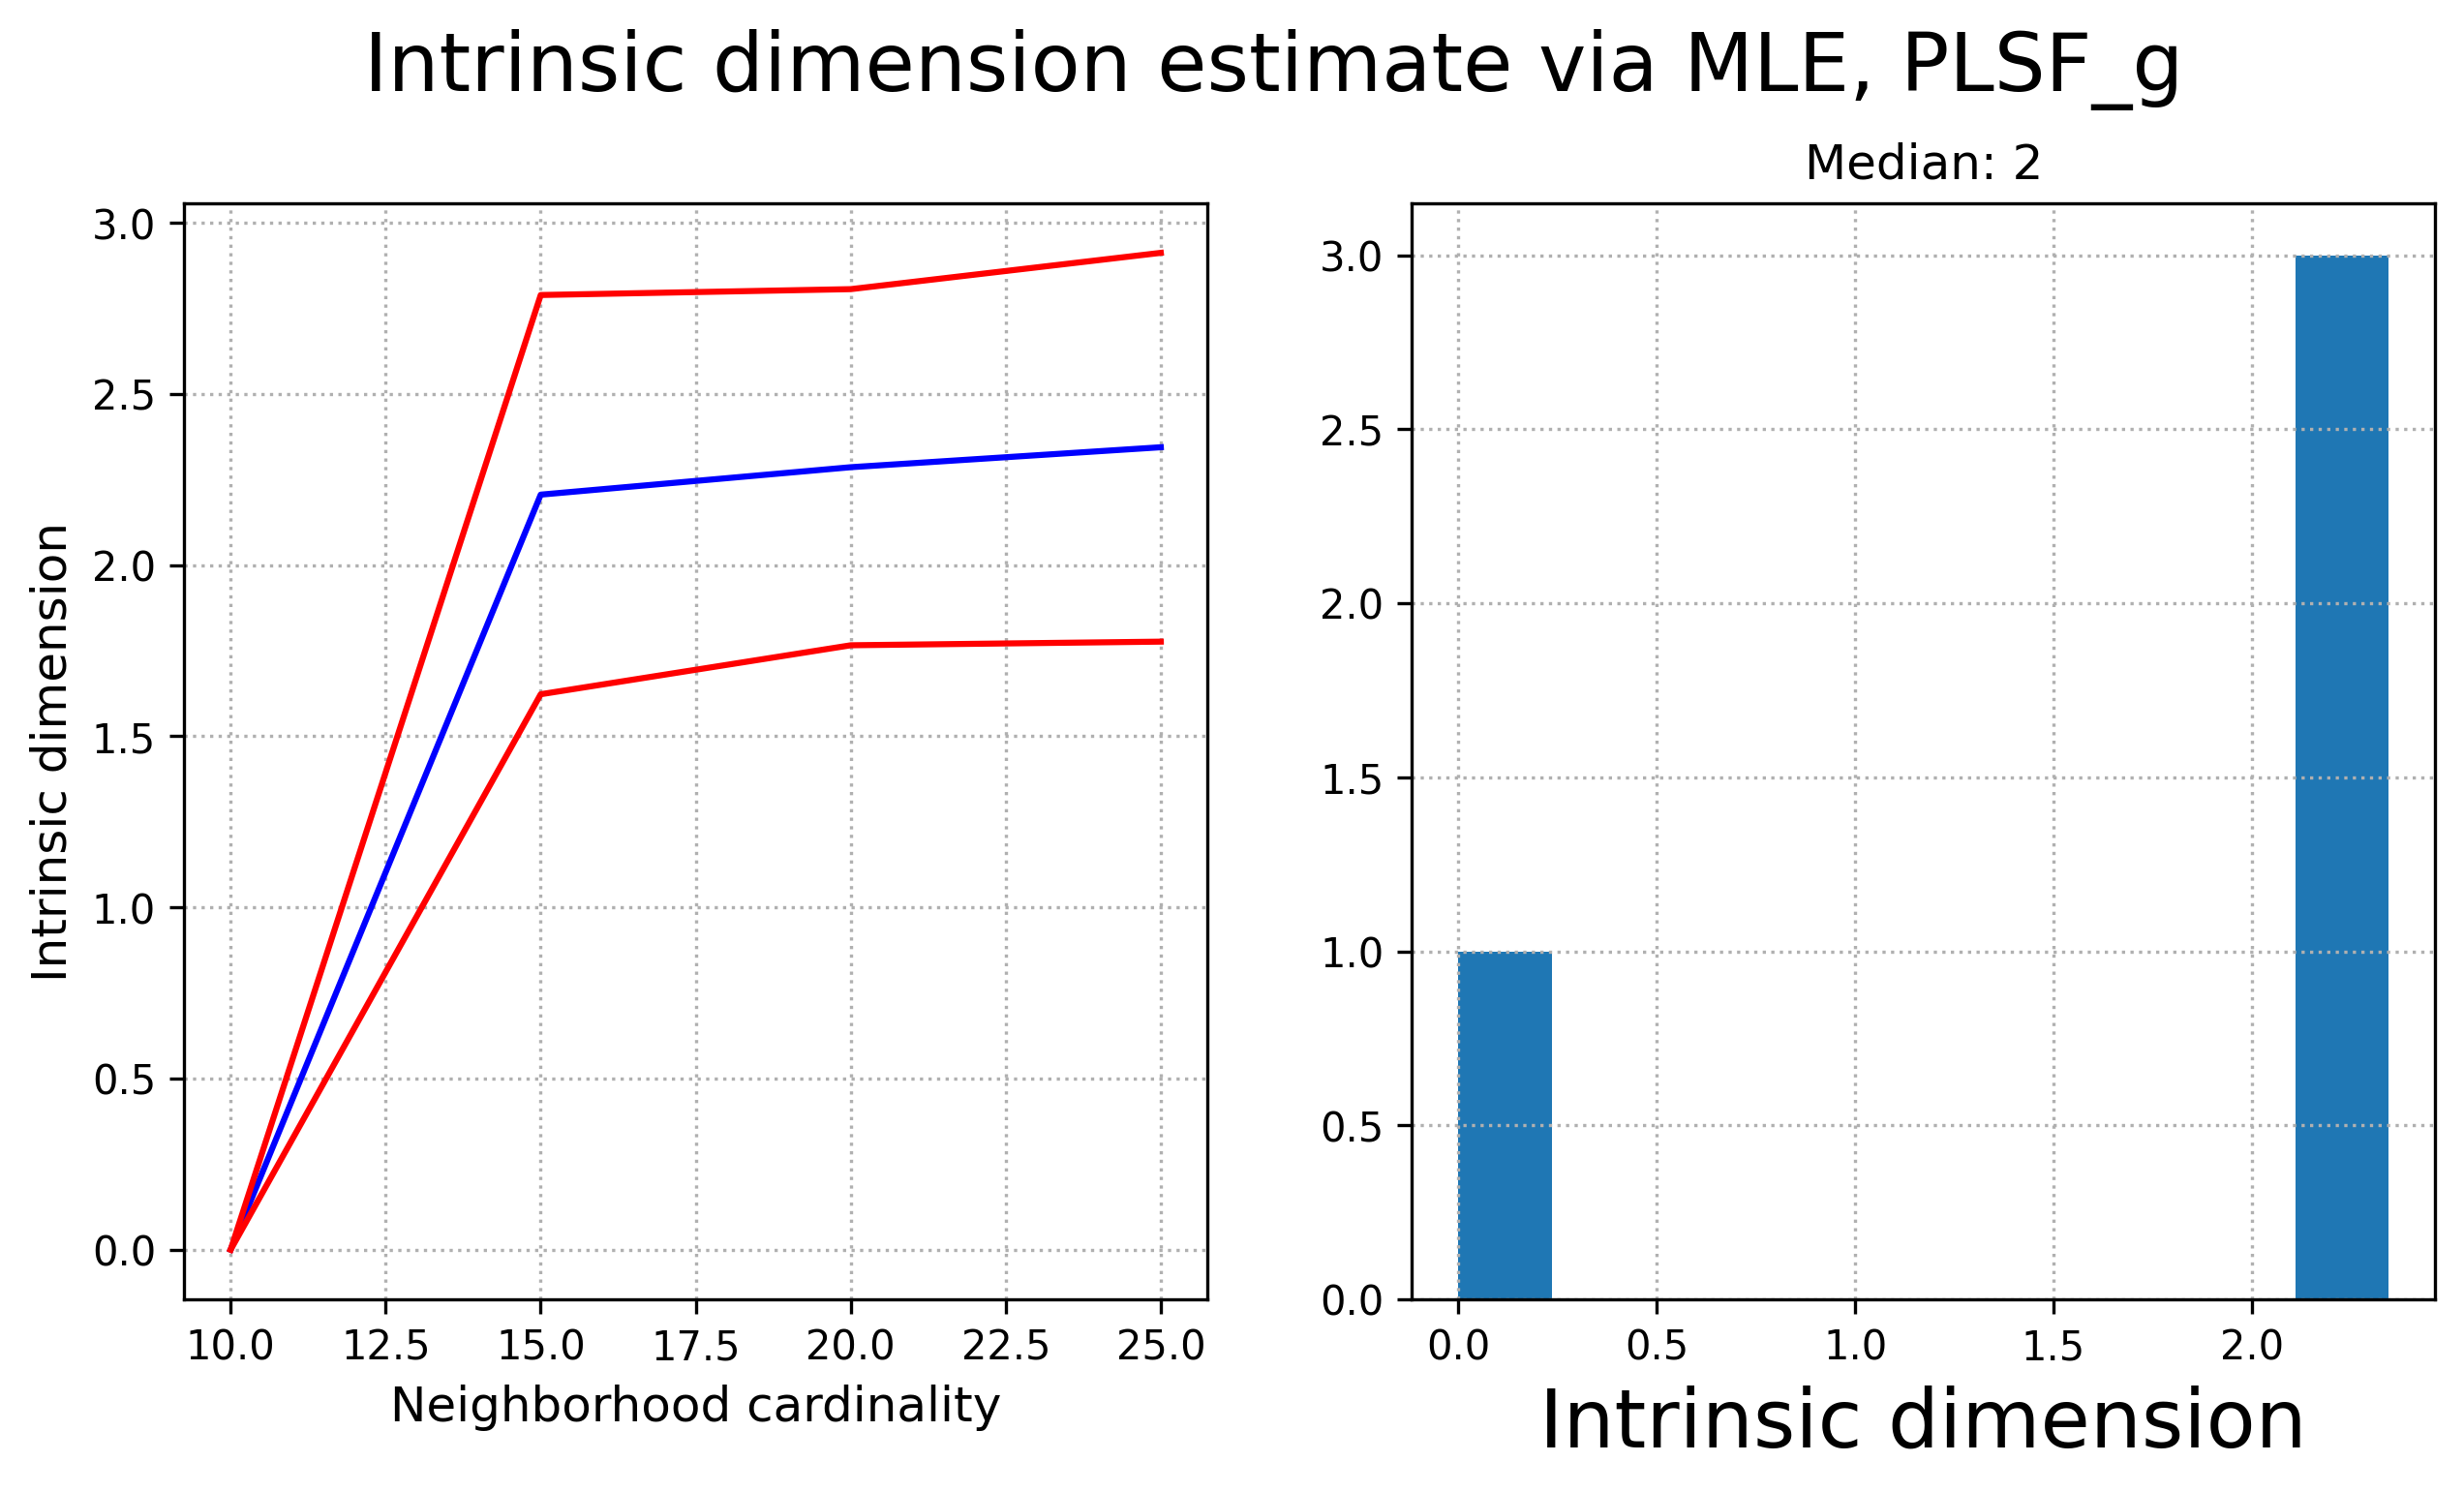

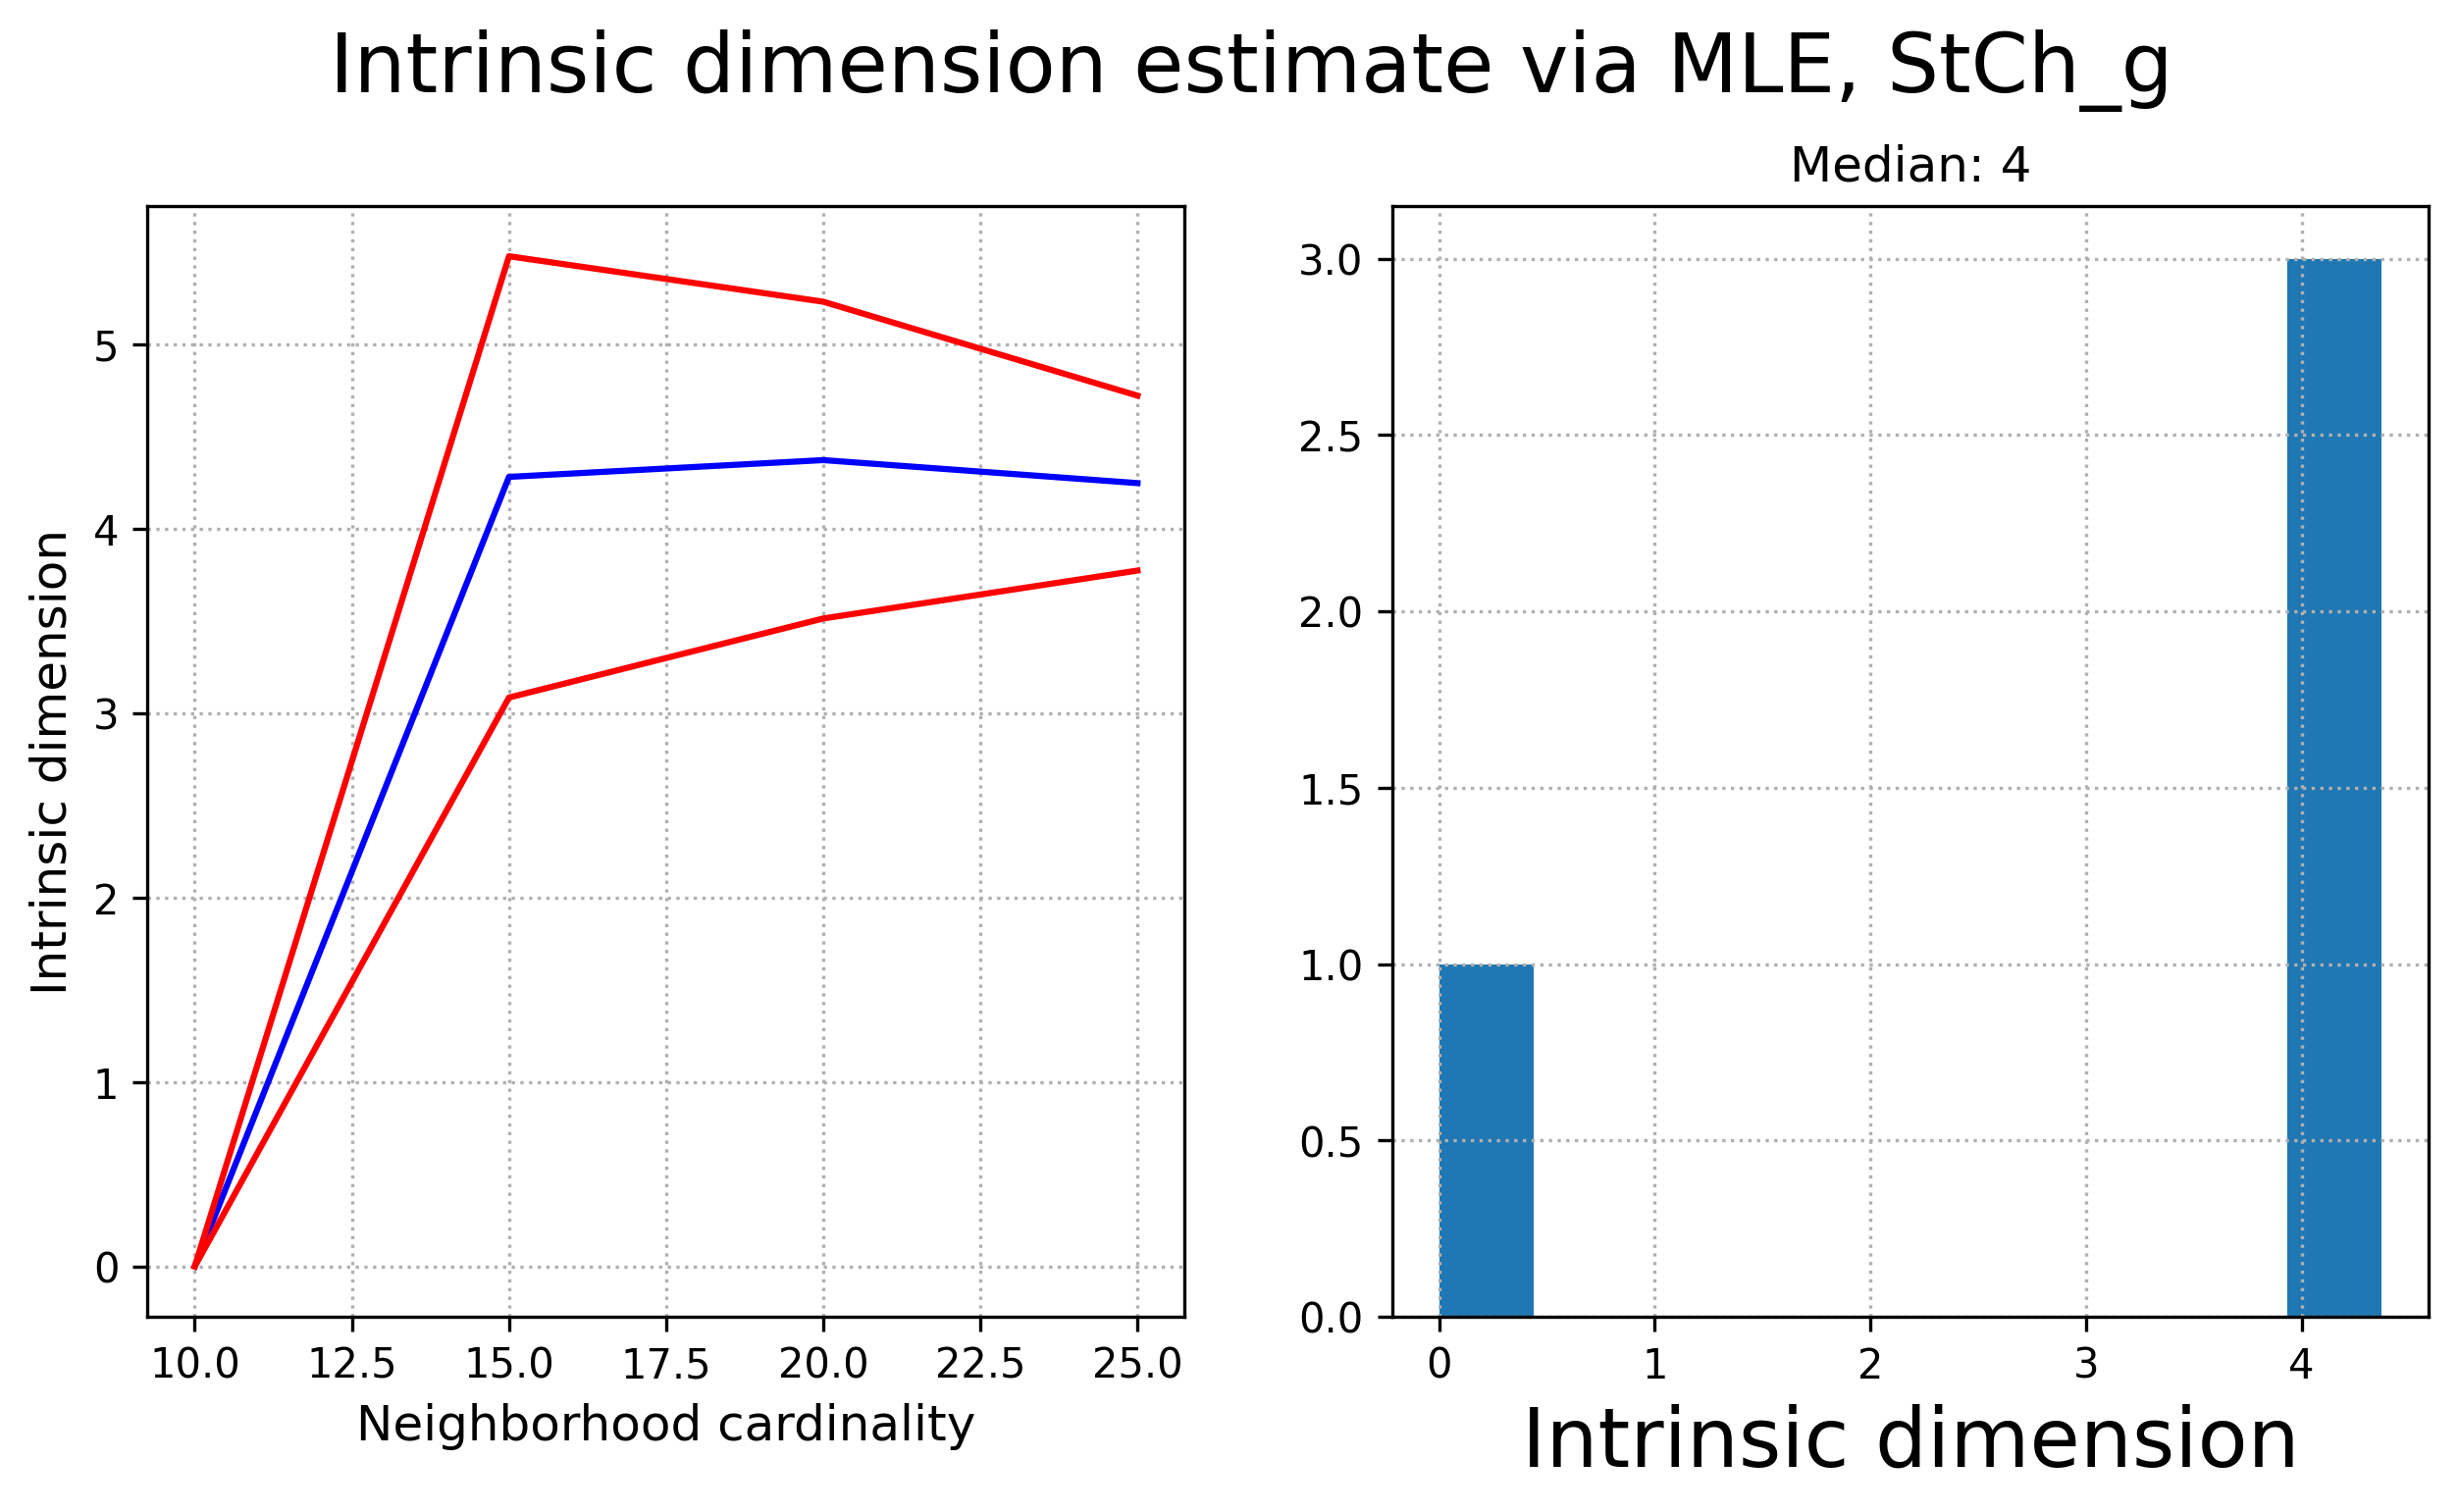

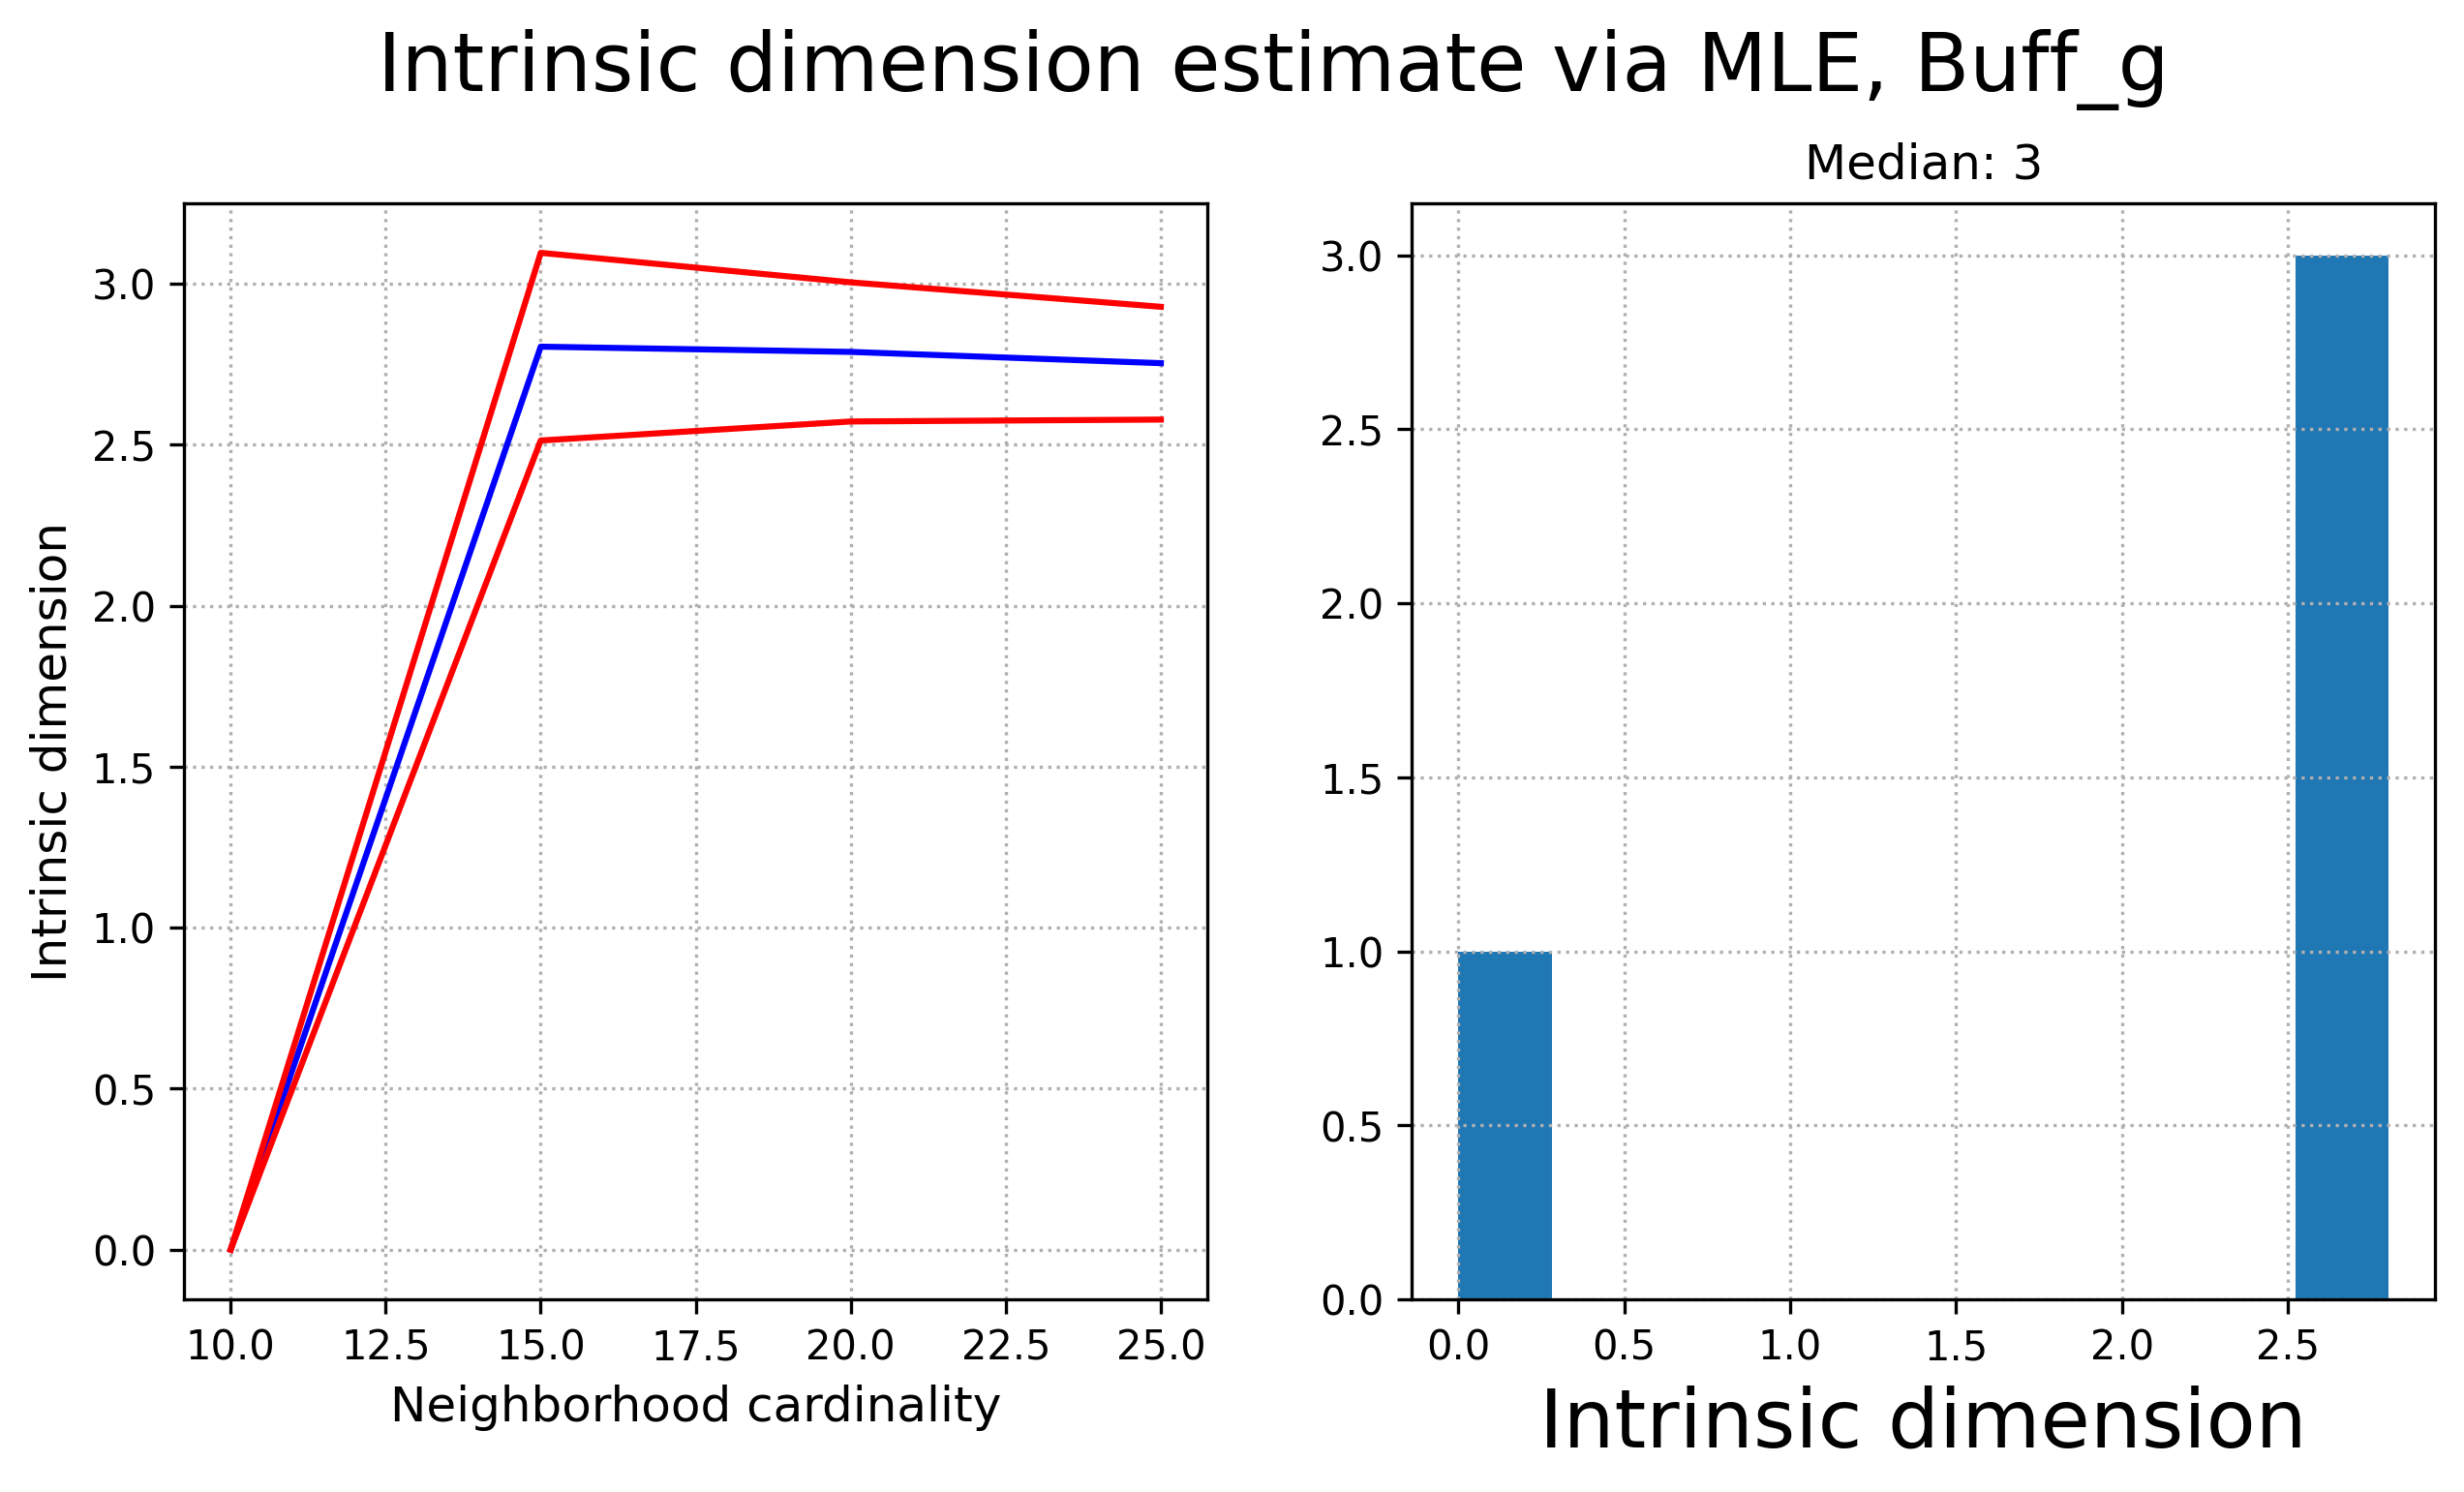

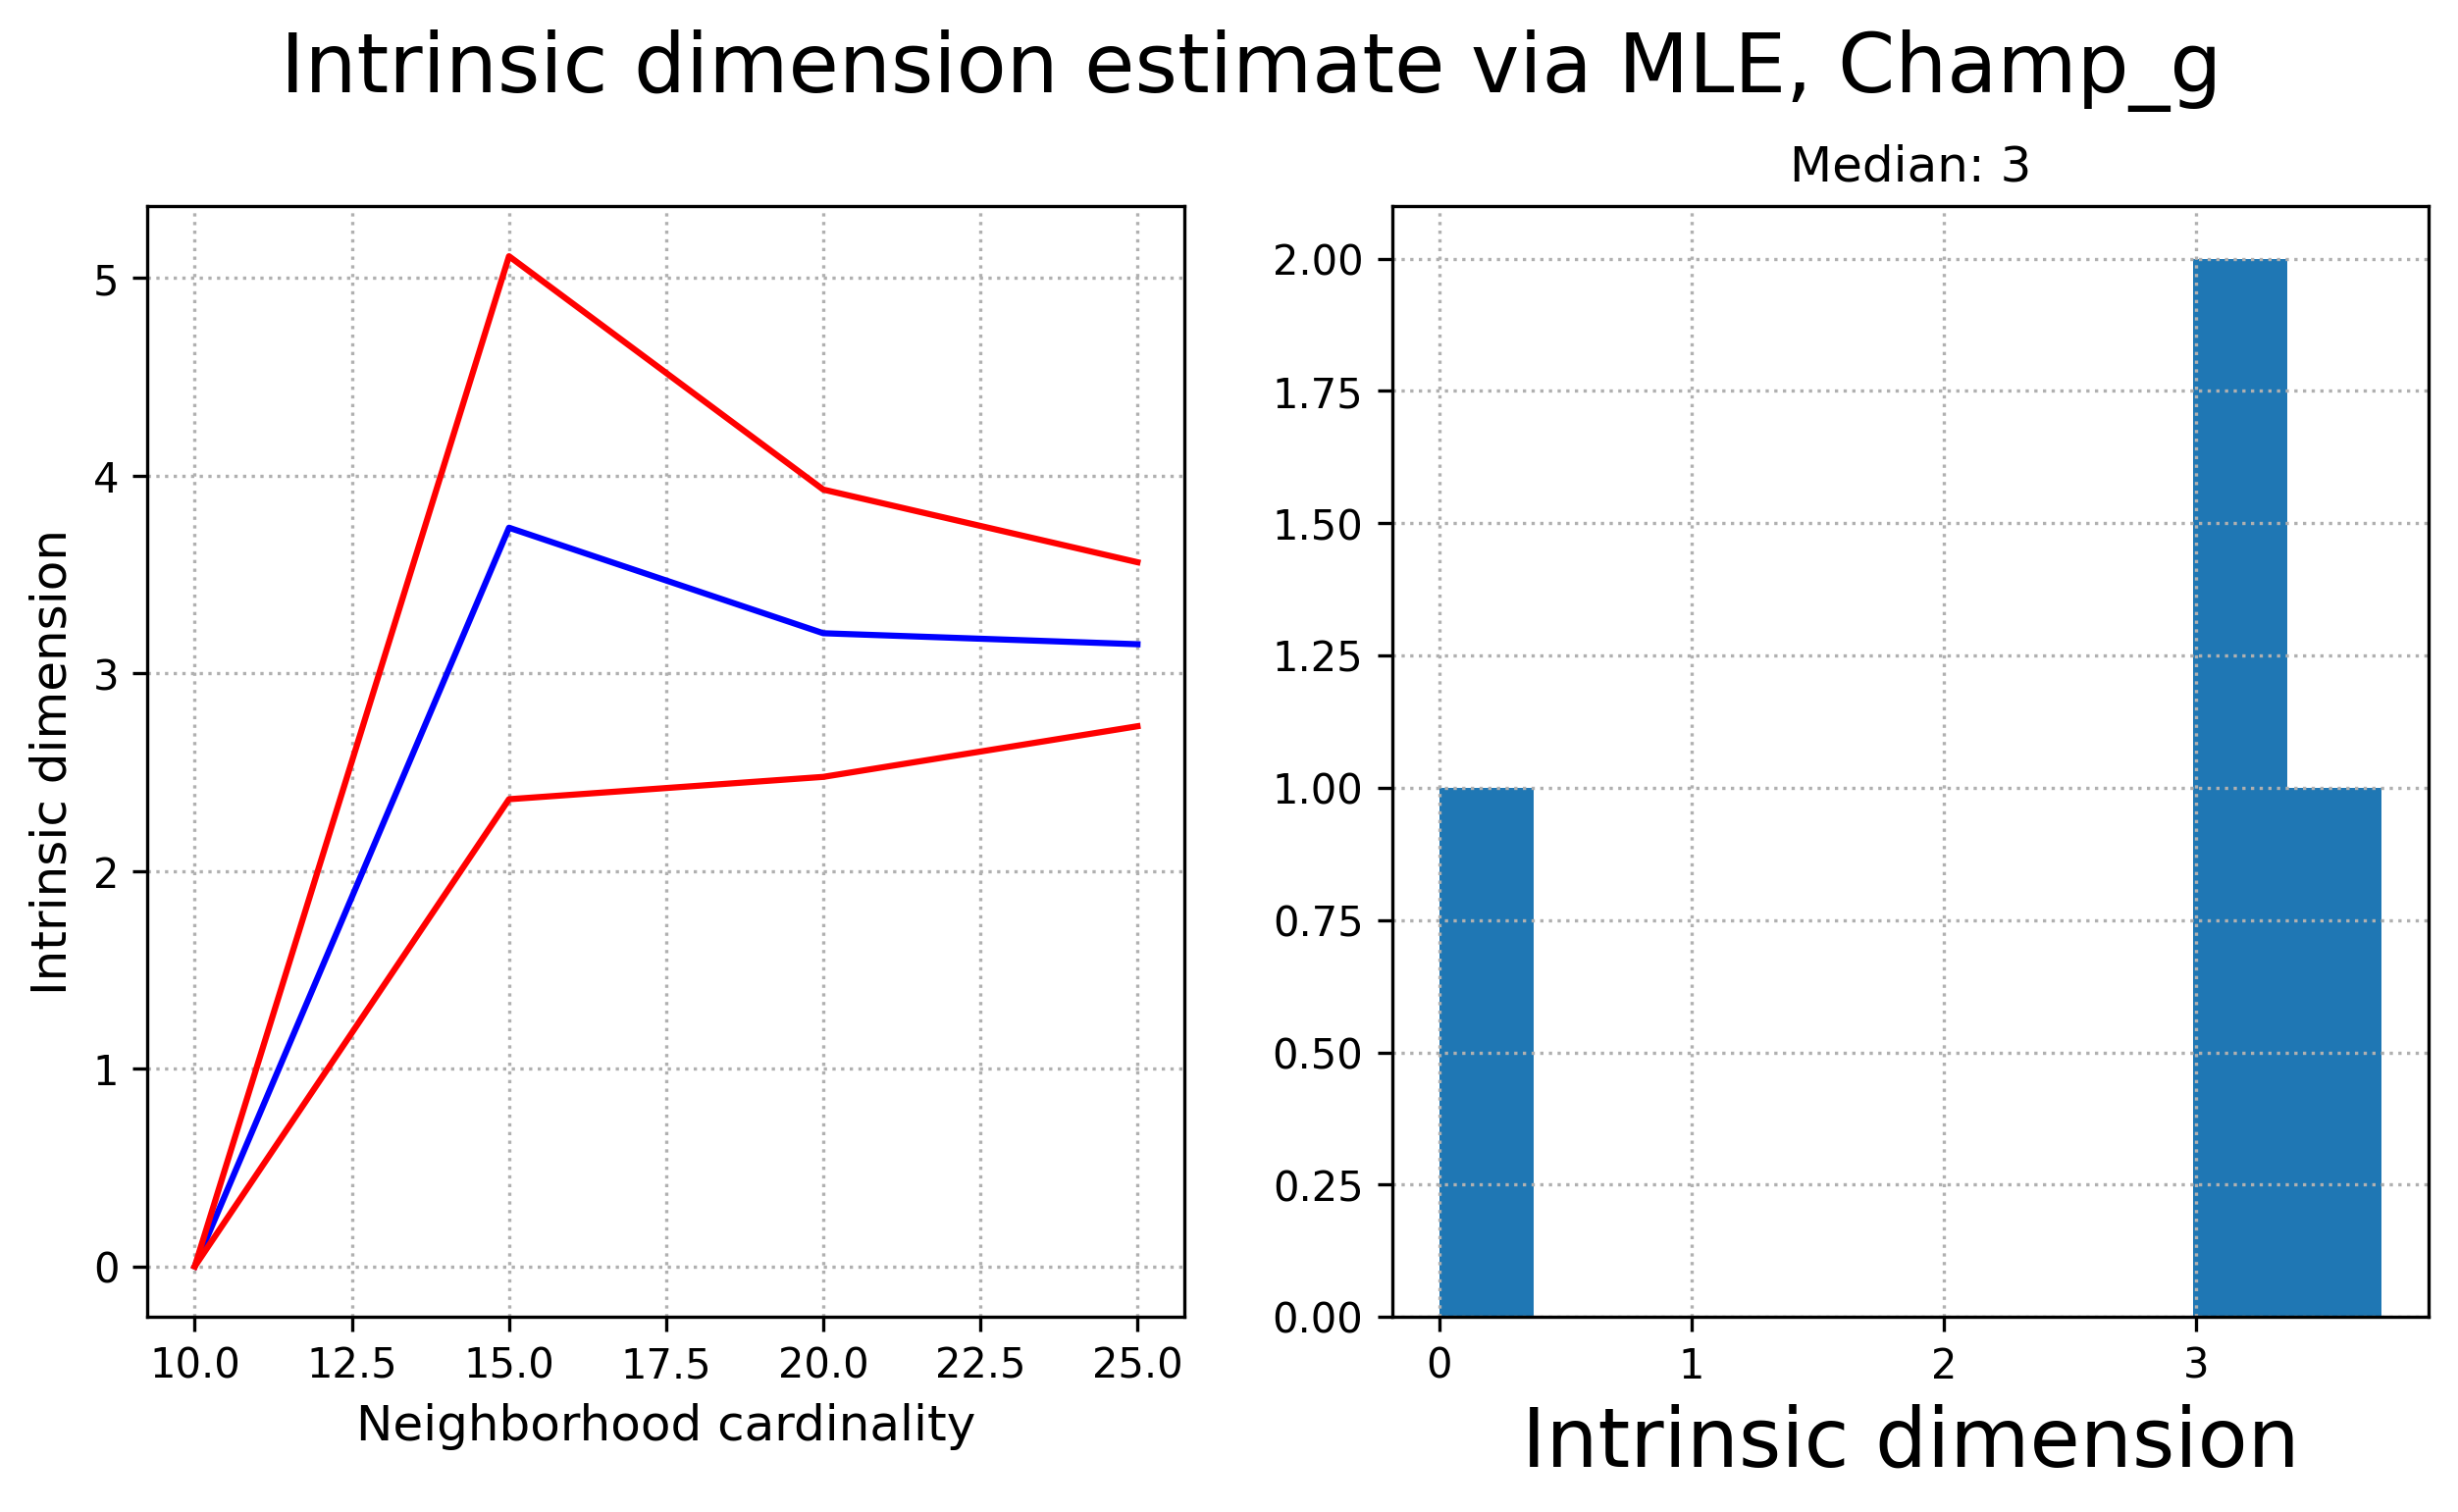

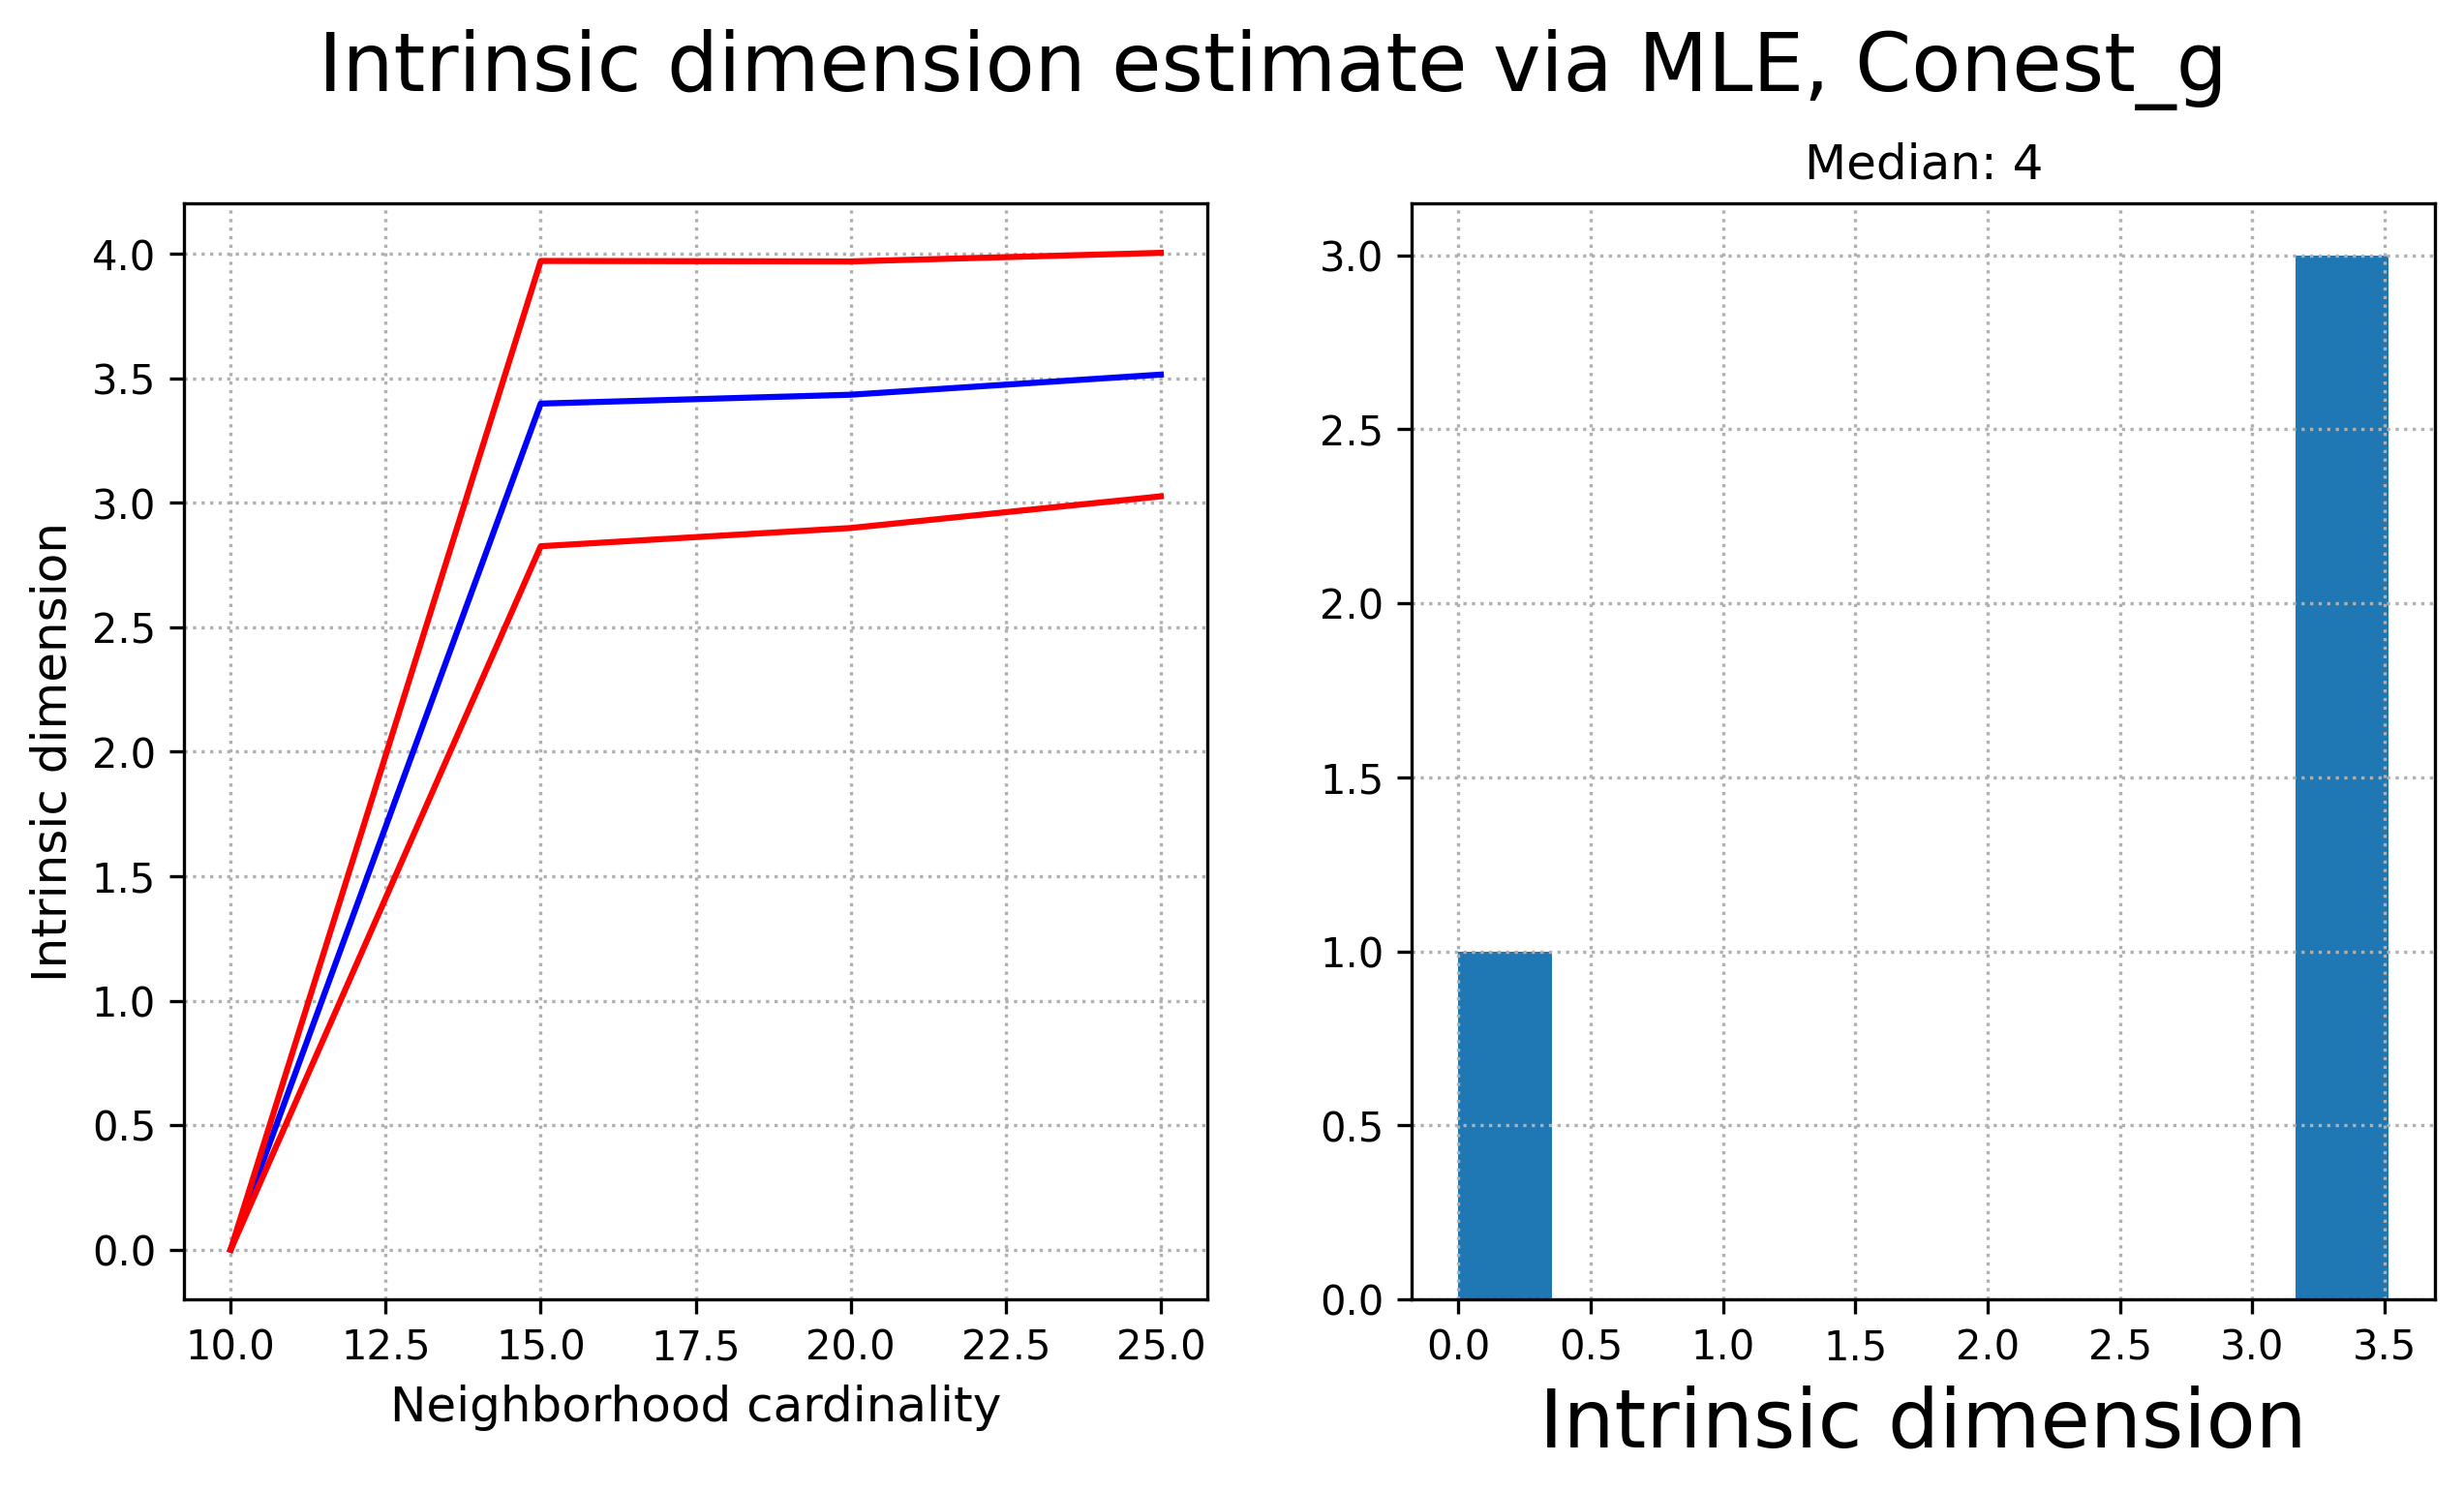

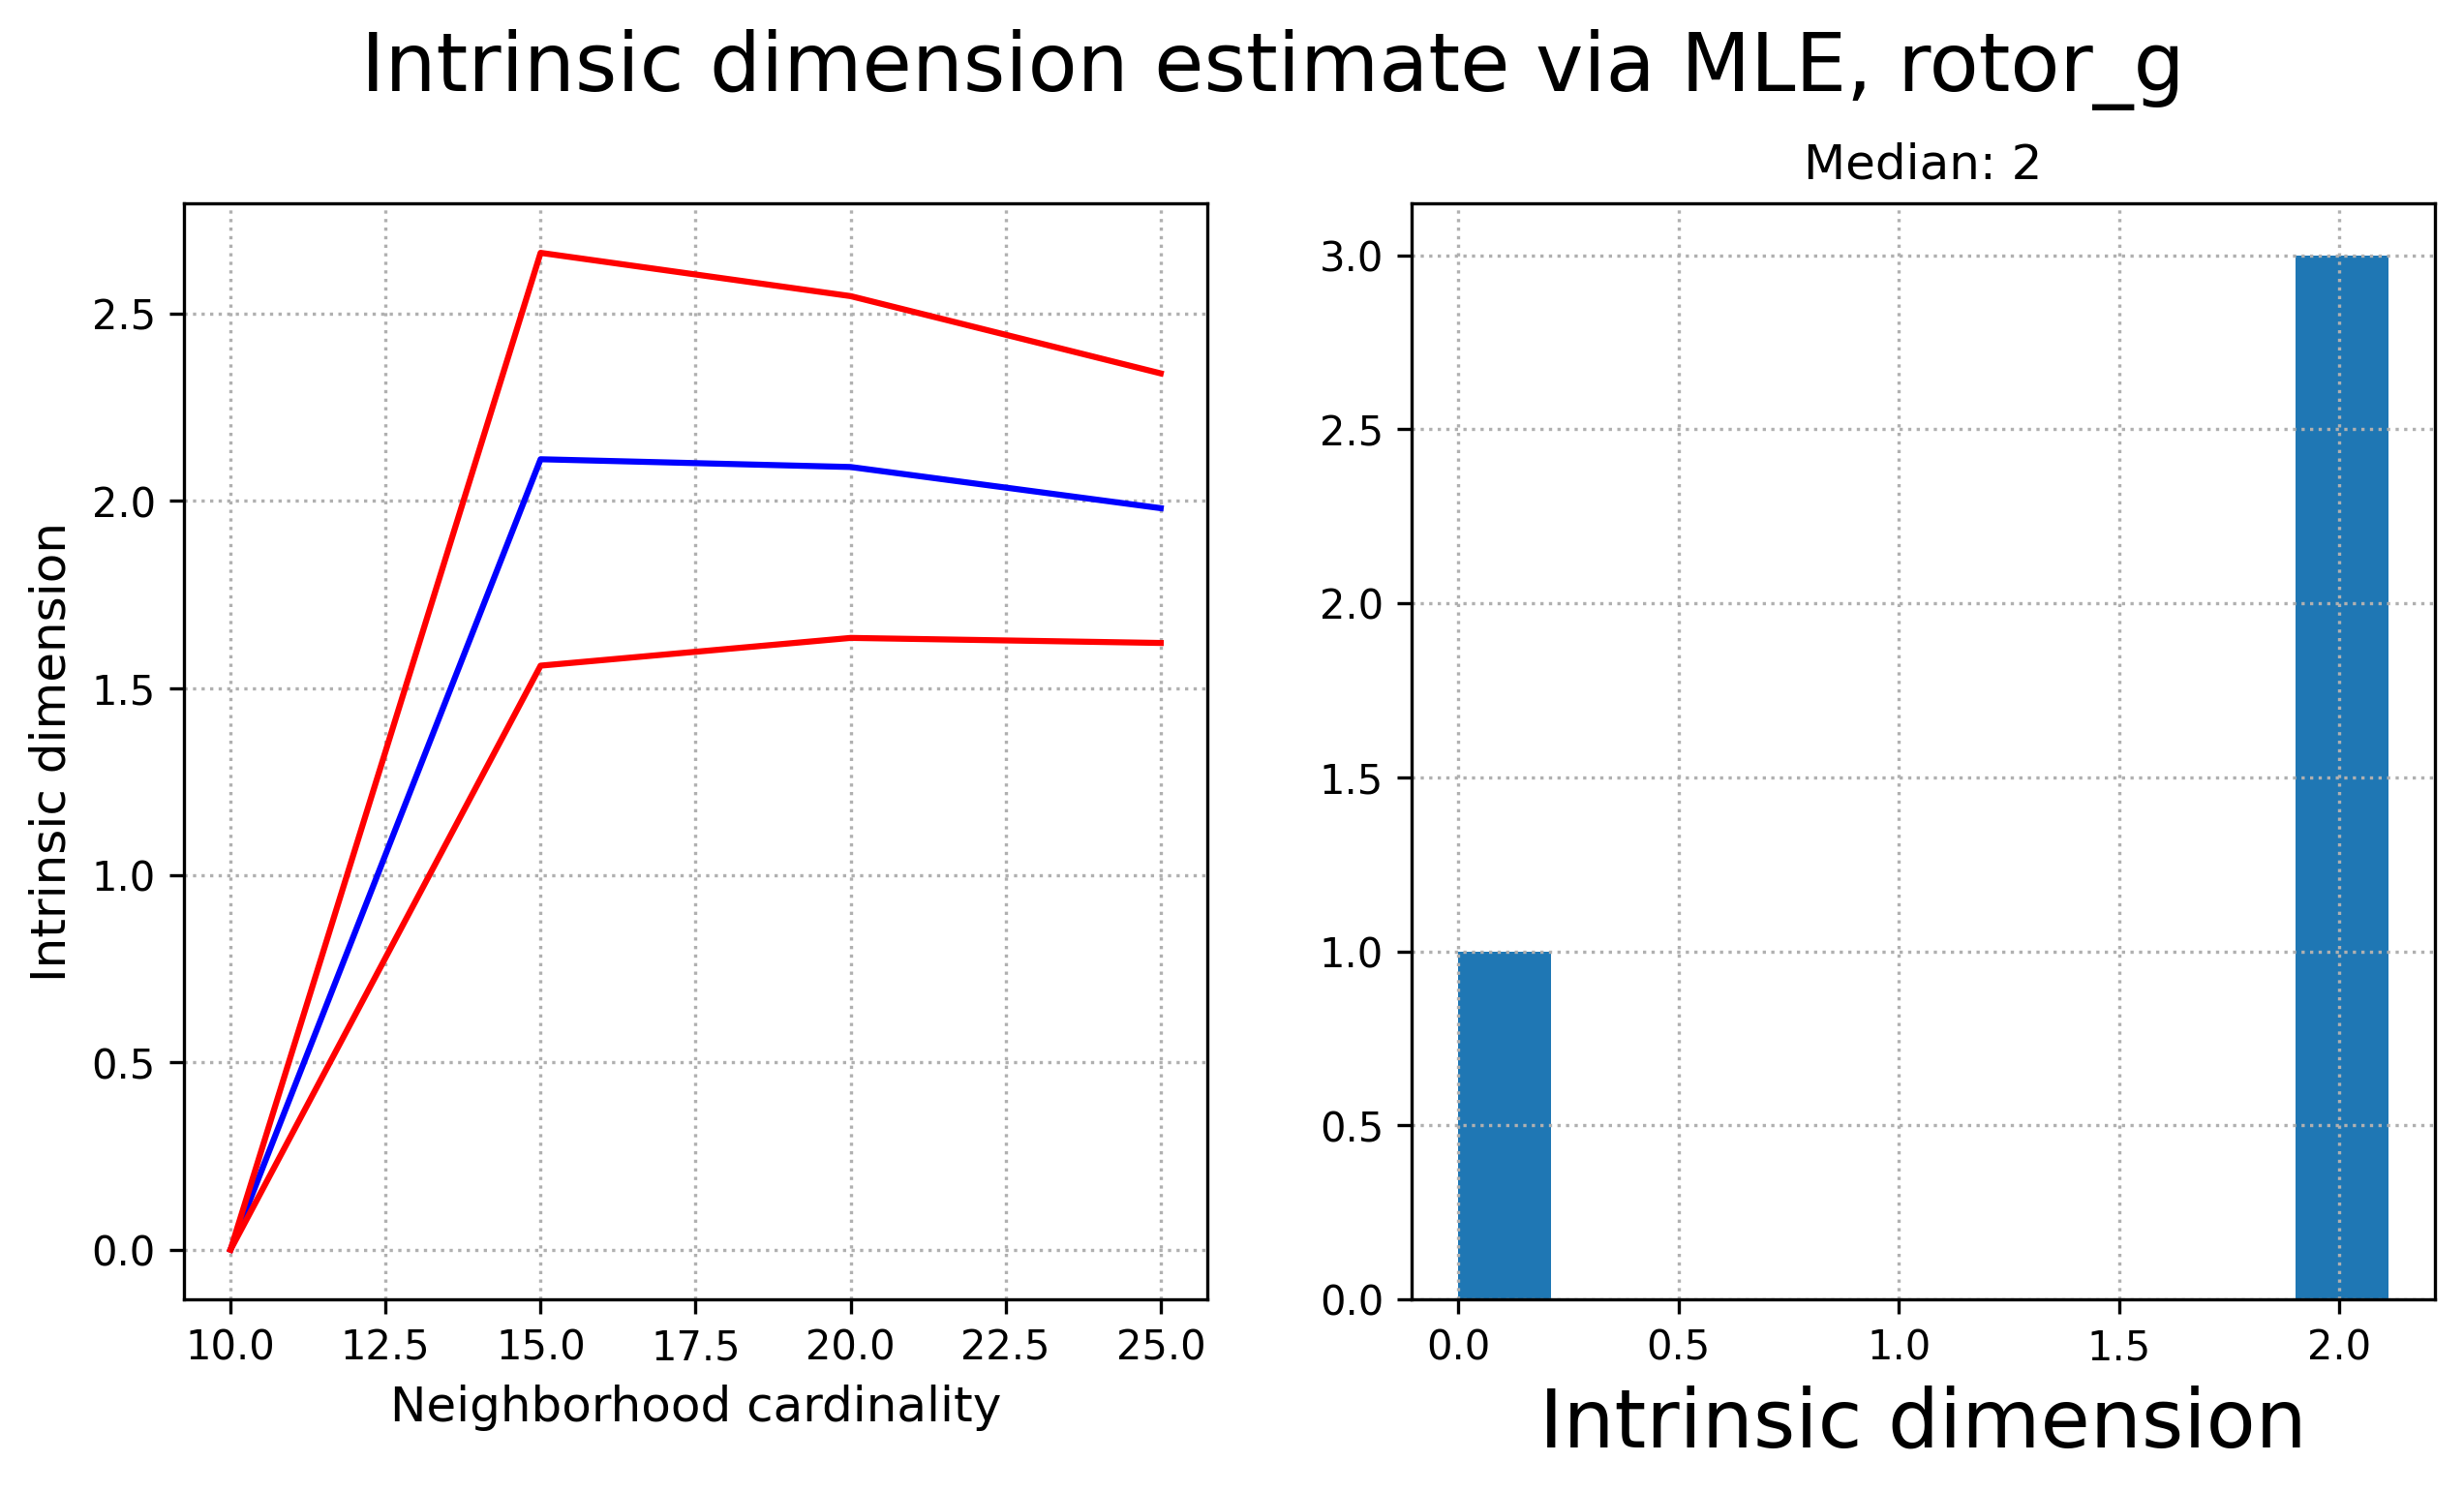

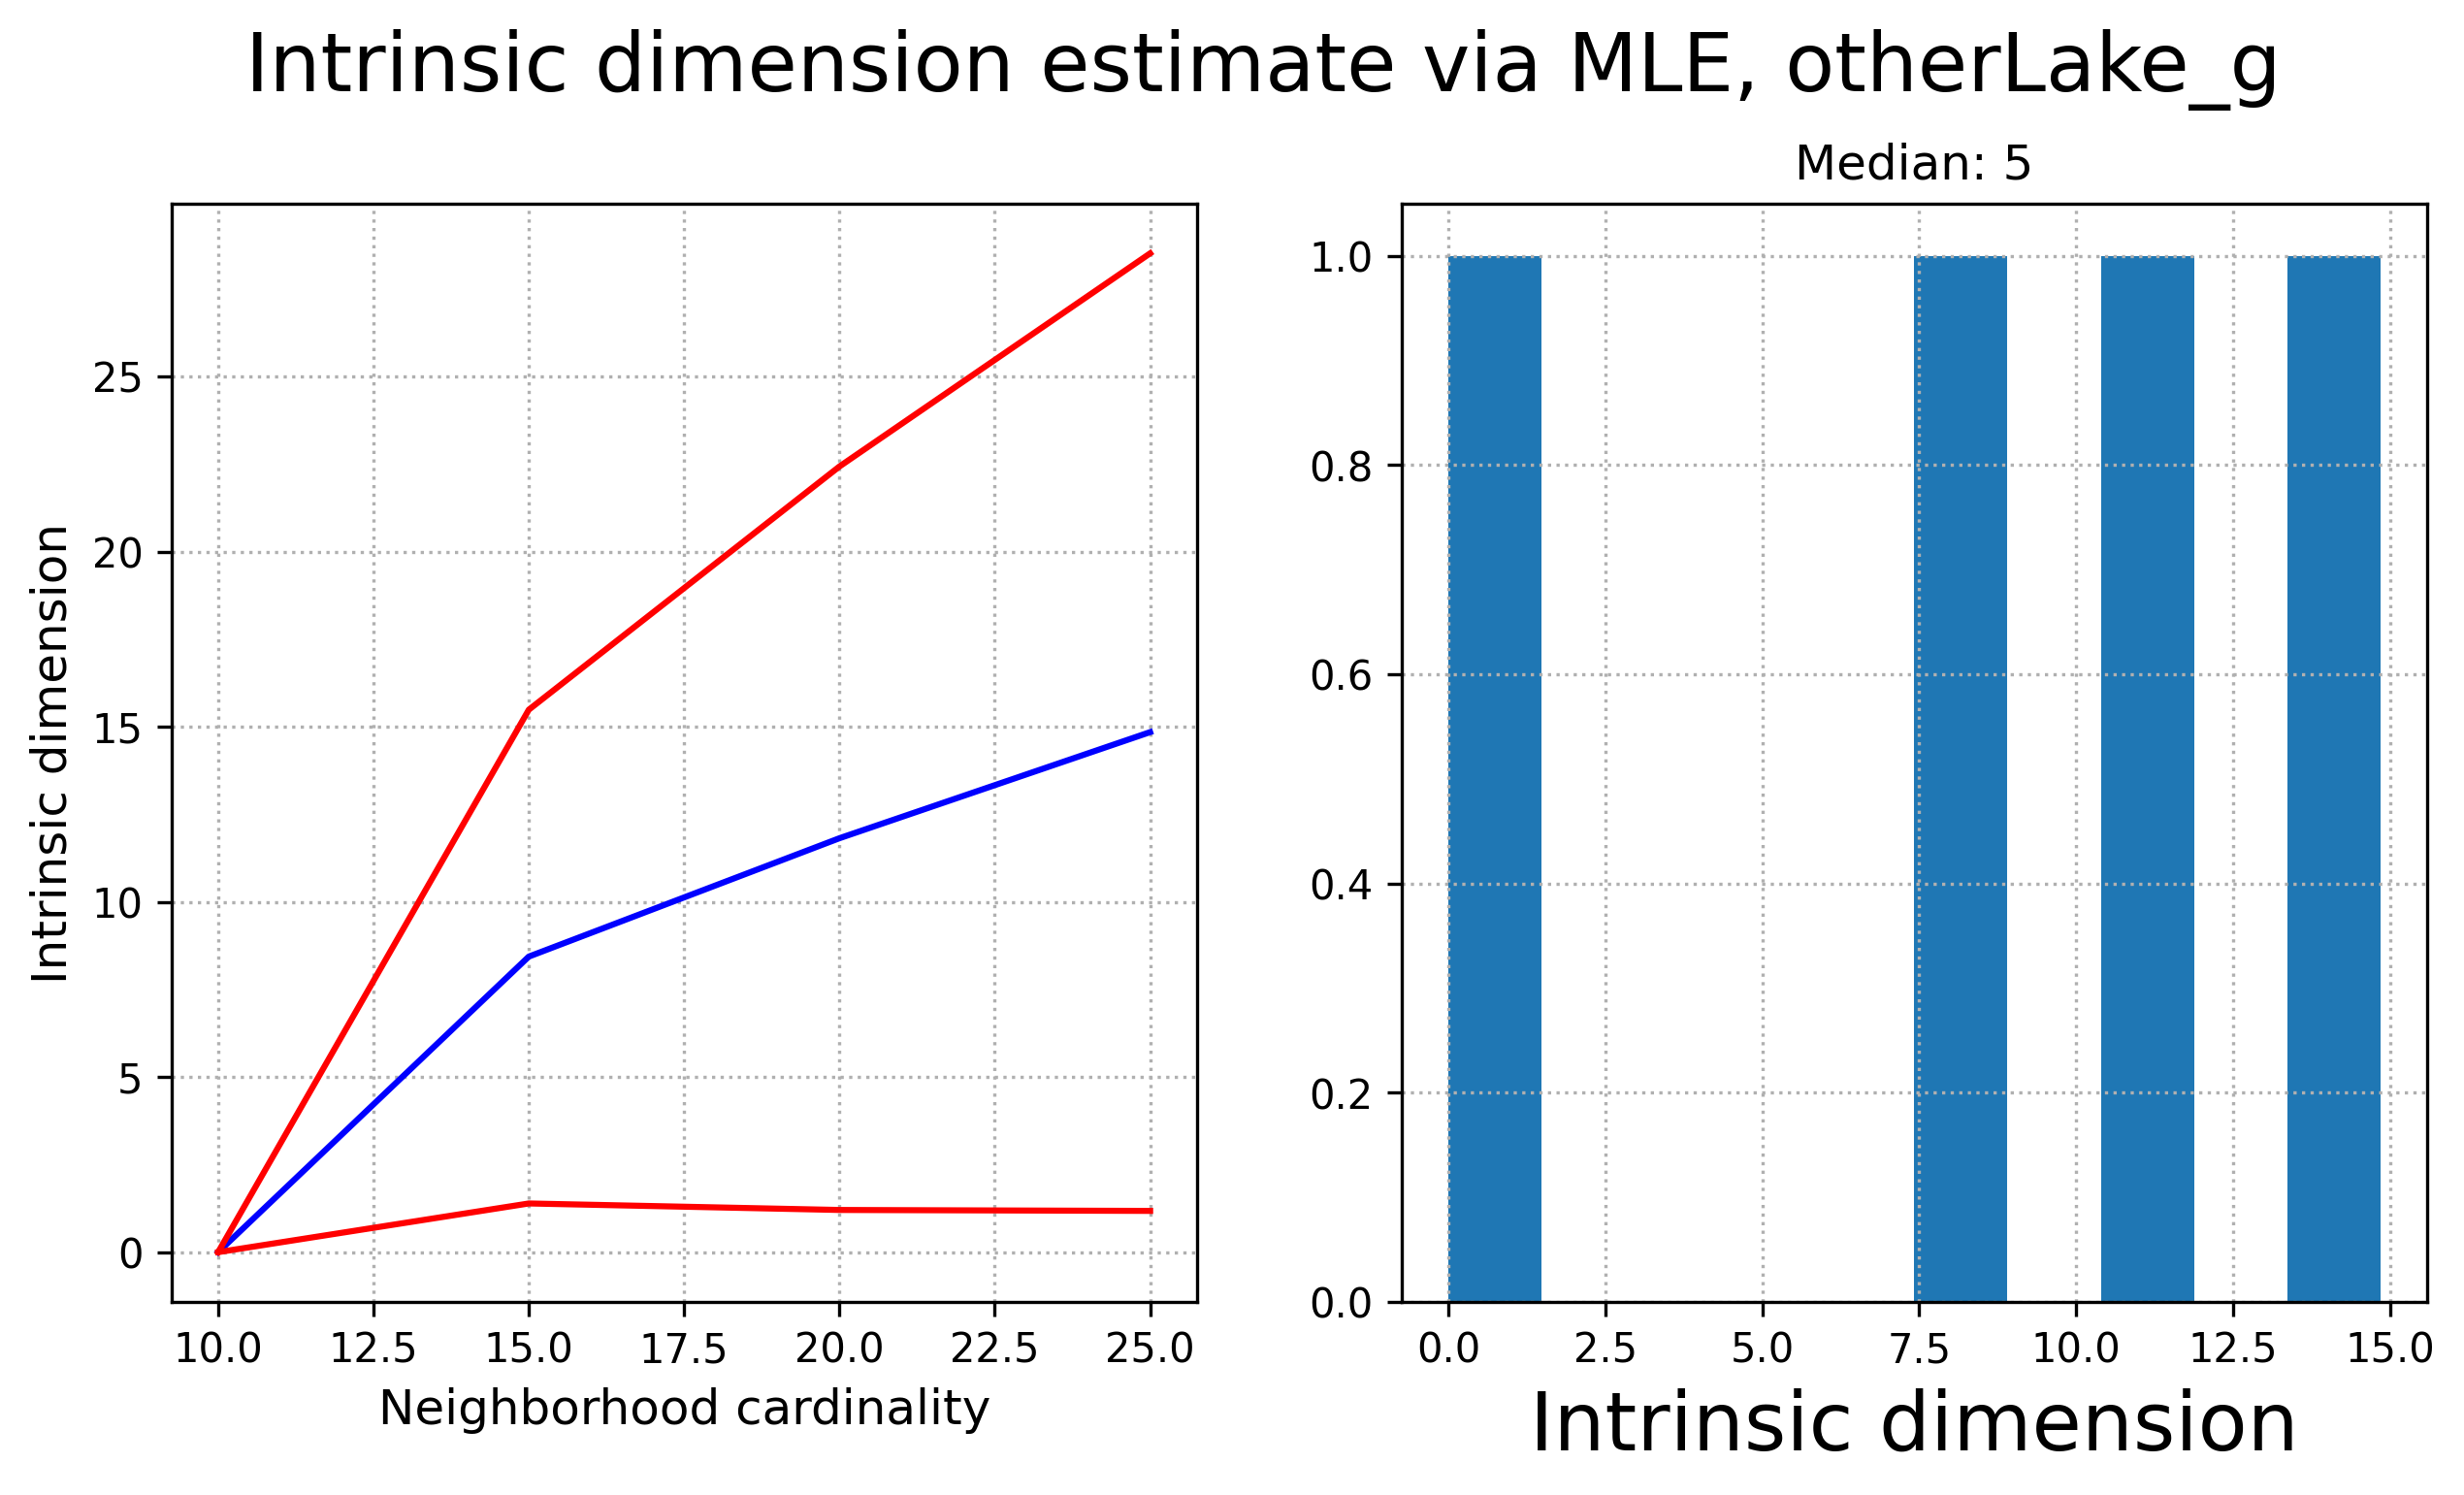

In [7]:
intrinsic_dims_med = {}
for label, intdim_k_repeated in indims.items():
    
    fig = plt.figure(figsize=(10,5), dpi=300)
    plt.suptitle(f"Intrinsic dimension estimate via MLE, {label}",fontsize=20, y=1)
    
    floor_n_ceil = np.concatenate((np.floor(np.mean(intdim_k_repeated, axis=0)).astype(int), 
                                    np.ceil(np.mean(intdim_k_repeated, axis=0)).astype(int)))
    
    plt.subplot(121)
    plt.xlabel("Neighborhood cardinality", fontsize=12)
    plt.ylabel("Intrinsic dimension", fontsize=12)
    plt.grid(linestyle='dotted')

    plt.plot(np.arange(intdim_k_repeated.shape[1]) * 5 + 10,\
             np.mean(intdim_k_repeated, axis=0), 'b')
    plt.plot(np.arange(intdim_k_repeated.shape[1]) * 5 + 10,\
             np.mean(intdim_k_repeated, axis=0) + np.std(intdim_k_repeated, axis=0), 'r')
    plt.plot(np.arange(intdim_k_repeated.shape[1]) * 5 + 10,\
             np.mean(intdim_k_repeated, axis=0) - np.std(intdim_k_repeated, axis=0), 'r')

    plt.subplot(122)
    plt.xlabel("Intrinsic dimension", fontsize=20)
    plt.grid(linestyle="dotted")

    plt.hist(intdim_k_repeated.mean(axis=0))
    med = int(np.ceil(np.percentile(intdim_k_repeated.flatten(),50)))
    plt.title(f'Median: {med}', y=1)
    intrinsic_dims_med[label] = med
    plt.show()

In [ ]:
# # uncomment for synthetic data
# np.save('./intrinsic_dims_pca_strict_synthetic', intrinsic_dims_med)

In [8]:
np.save(f'./intrinsic_dims_pca_strict{DATA_SPECIFICATION}', intrinsic_dims_med)